In [519]:
import numpy as np
import pandas as pd
import time
import math

import matplotlib.pyplot as plt

In [520]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [521]:
file_id = '1I1Sk4PmZuiCH5gwJfpJ3f-eBEds7Cx0p' # features.txt
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('features.txt')

file_id = '1OAaPYyI94DbFZpGrpwSvvHQ-RwT7X1sE' # target.txt
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('target.txt')

In [522]:
X = np.loadtxt('features.txt', delimiter = ',')
y = np.loadtxt('target.txt', delimiter = ',')

## Batch Gradient Descent

In [523]:
def random_shuffle(arg1, *args):
    shuffler = np.random.permutation(len(arg1))
    result = [arg1[shuffler]]
    for arg in args:
        assert len(shuffler) == len(arg)
        result.append(arg[shuffler])
    
    return result

In [524]:
def get_cost(X, y, C, w, b):
    return 1/2 * (np.linalg.norm(w ** 2)) + C * np.sum( np.maximum(0, 1 - y * (w @ X.T + b)) )

In [525]:
def update_wi(X, y, C, w_prev, b, i, j):
    _xi = X[i]
    _xij = X[i, j]
    _y = float(y[i])
    dw = w_prev[j]

    loss_condition = _y * (_xi @ w_prev + b)
    if loss_condition < 1:
        dw = C * (-_y * _xij)
    
    return dw

In [526]:
def get_w(X, y, C, w_prev, b, eta, batch_size):
    n, d = X.shape
    w = w_prev.copy()

    for j in range(d):
        dw = w_prev[j]
        for i in range(batch_size):
            dw += update_wi(X, y, C, w_prev, b, i, j)
        
        w[j] = w_prev[j] - eta * dw

    return w

In [527]:
def get_w_stochastic(X, y, C, w_prev, b, eta, i):
    n, d = X.shape
    w = w_prev.copy()

    for j in range(d):
        dw = w_prev[j]
        dw += update_wi(X, y, C, w_prev, b, i, j)
        
        w[j] = w_prev[j] - eta * dw

    return w

In [528]:
def update_bi(X, y, C, w_prev, b_prev, i):
    db = 0

    _xi = X[i]
    _y = float(y[i])

    loss_condition = _y * (_xi @ w + b_prev)
    if loss_condition < 1:
        db = C * (-_y)
    
    return db

In [529]:
def get_b(X, y, C, w, b_prev, eta, batch_size):
    n, d = X.shape
    db = 0

    for i in range(batch_size):
        db += update_bi(X, y, C, w, b_prev, i)
        
    b = b_prev - eta * db

    return b

In [530]:
def get_b_stochastic(X, y, C, w, b_prev, eta, i):
    n, d = X.shape
    db = 0
    
    db += update_bi(X, y, C, w, b_prev, i)
        
    b = b_prev - eta * db

    return b

In [531]:
def batch_gradient_descent(X, y, C, w, b, eta, epsilon):
    n, d = X.shape
    beta = n

    cost_values = []

    t, k = 0, 0
    while True:
        cost_values.append( get_cost(X, y, C, w, b) )
        # print(cost_values[-1])

        # Update w and b
        w_new = get_w(X, y, C, w, b, eta, beta)
        b_new = get_b(X, y, C, w, b, eta, beta)

        w = w_new.copy()
        b = b_new

        k = (k + 1)  % math.ceil(n / beta)
        t += 1

        # Compute new cost
        cost = get_cost(X, y, C, w, b)
        stopping_criterion = (abs(cost_values[-1] - cost) / cost_values[-1])  * 100
        if stopping_criterion < epsilon:
            cost_values.append(cost)
            break
    
    return cost_values

In [532]:
def stochastic_gradient_descent(X, y, C, w, b, eta, epsilon):
    X, y = random_shuffle(X, y)
    
    n, d = X.shape
    beta = n

    delta_cost = 0
    cost_values = []

    t, k = 0, 0
    i = 0
    while True:
        cost_values.append( get_cost(X, y, C, w, b) )
        # print(cost_values[-1])

        # Update w and b
        w_new = get_w_stochastic(X, y, C, w, b, eta, i)
        # b_new = get_b_stochastic(X, y, C, w, b, eta, i)
        
        db = 0
        _xi = X[i]
        _y = float(y[i])

        loss_condition = _y * (_xi @ w + b)
        if loss_condition < 1:
            db = C * (-_y)
        b_new = b - eta * db

        w = w_new.copy()
        b = b_new

        k = (k + 1)  % math.ceil(n / beta)
        t += 1

        i = (i + 1) % n

        # Compute new cost
        cost = get_cost(X, y, C, w, b)
        cost_change_percentage = (abs(cost_values[-1] - cost) / cost_values[-1])  * 100
        delta_cost = .5 * delta_cost + 0.5 * cost_change_percentage
        if delta_cost < epsilon:
            cost_values.append(cost)
            break
    
    return cost_values

In [533]:
def mini_batch_gradient_descent(X, y, C, w, b, eta, epsilon, batch_size):
    X, y = random_shuffle(X, y)
    
    n, d = X.shape
    beta = batch_size

    cost_values = []

    t, k = 0, 0
    while True:
        cost_values.append( get_cost(X, y, C, w, b) )
        # print(cost_values[-1])

        # Update w and b
        w_new = get_w(X, y, C, w, b, eta, beta)
        b_new = get_b(X, y, C, w, b, eta, beta)

        w = w_new.copy()
        b = b_new

        k = (k + 1)  % math.ceil(n / beta)
        t += 1

        # Compute new cost
        cost = get_cost(X, y, C, w, b)
        stopping_criterion = (abs(cost_values[-1] - cost) / cost_values[-1])  * 100
        if stopping_criterion < epsilon:
            cost_values.append(cost)
            break
    
    return cost_values

In [534]:
n, d = X.shape
C = 100
w = np.zeros(d)
b = 0.0

In [535]:
start_time = time.time()

eta = 0.0000003
epsilon = 0.25
bgd_cost_values = batch_gradient_descent(X, y, C, w, b, eta, epsilon)

end_time = time.time()
elapsed_time_bgd = end_time - start_time

print(f'Batch Gradient Descent: {elapsed_time_bgd} seconds :: {len(bgd_cost_values)} iterations.')

Batch Gradient Descent: 14.835629224777222 seconds :: 6 iterations.


In [536]:
start_time = time.time()

eta = 0.0001
epsilon = 0.001
sgd_cost_values = stochastic_gradient_descent(X, y, C, w, b, eta, epsilon)

end_time = time.time()
elapsed_time_sgd = end_time - start_time

print(f'Stochastic Gradient Descent: {elapsed_time_sgd} seconds :: {len(sgd_cost_values)} iterations.')

Stochastic Gradient Descent: 1.3054814338684082 seconds :: 571 iterations.


In [537]:
start_time = time.time()

eta = 0.00001
epsilon = 0.01
batch_size = 20
mbgd_cost_values = mini_batch_gradient_descent(X, y, C, w, b, eta, epsilon, batch_size)

end_time = time.time()
elapsed_time_mbgd = end_time - start_time

print(f'Mini Batch Gradient Descent: {elapsed_time_mbgd} seconds :: {len(mbgd_cost_values)} iterations.')

Mini Batch Gradient Descent: 0.31836724281311035 seconds :: 16 iterations.


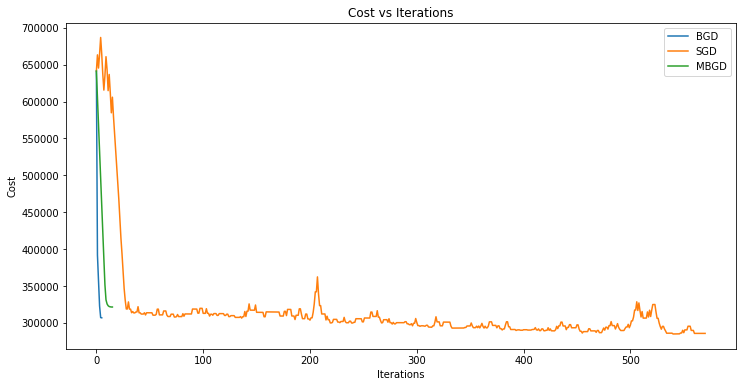

In [538]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(bgd_cost_values)), bgd_cost_values, label = 'BGD')
plt.plot(np.arange(len(sgd_cost_values)), sgd_cost_values, label = 'SGD')
plt.plot(np.arange(len(mbgd_cost_values)), mbgd_cost_values, label = 'MBGD')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations')
plt.legend()
plt.savefig('q1.png')
plt.show()